In [1]:
# pip install directly into notebook
%pip install sklearn
%pip install pandas
%pip install imbalanced-learn
%pip install seaborn

You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/robert/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# TODO: consider making list of dependencies for TA to install when running this notebook
import sklearn as sk
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# disable warning for chained assignment (not necessary but cleans up the project)
pd.options.mode.chained_assignment = None

In [4]:
# taken from kaggle example
class ReplaceZeroTransformer():
    """Eliminates Zero values from tempo columns and replace it 
       with the median or mean of non-zero values as specified.
       defaut is set to 'median'.
    """

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [5]:
# Import track data
usecols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence']
dataset = pd.read_csv("data.csv", header = 0, usecols=usecols)

# Remove rows duplicated by ignoring some columns
dataset = dataset[~dataset.duplicated()==1]

# Normalize columns having values outside [0, 1]
scaler = MinMaxScaler()
# cols_to_normalize = ['duration_ms', 'key', 'loudness', 'popularity', 'tempo']
cols_to_normalize = ['duration_ms', 'loudness', 'tempo']
dataset[cols_to_normalize] = scaler.fit_transform(dataset[cols_to_normalize])

# print(dataset)

Non-Explicit songs / total songs = 0.9314123543548132
Major key songs / total songs = 0.7043086884735386


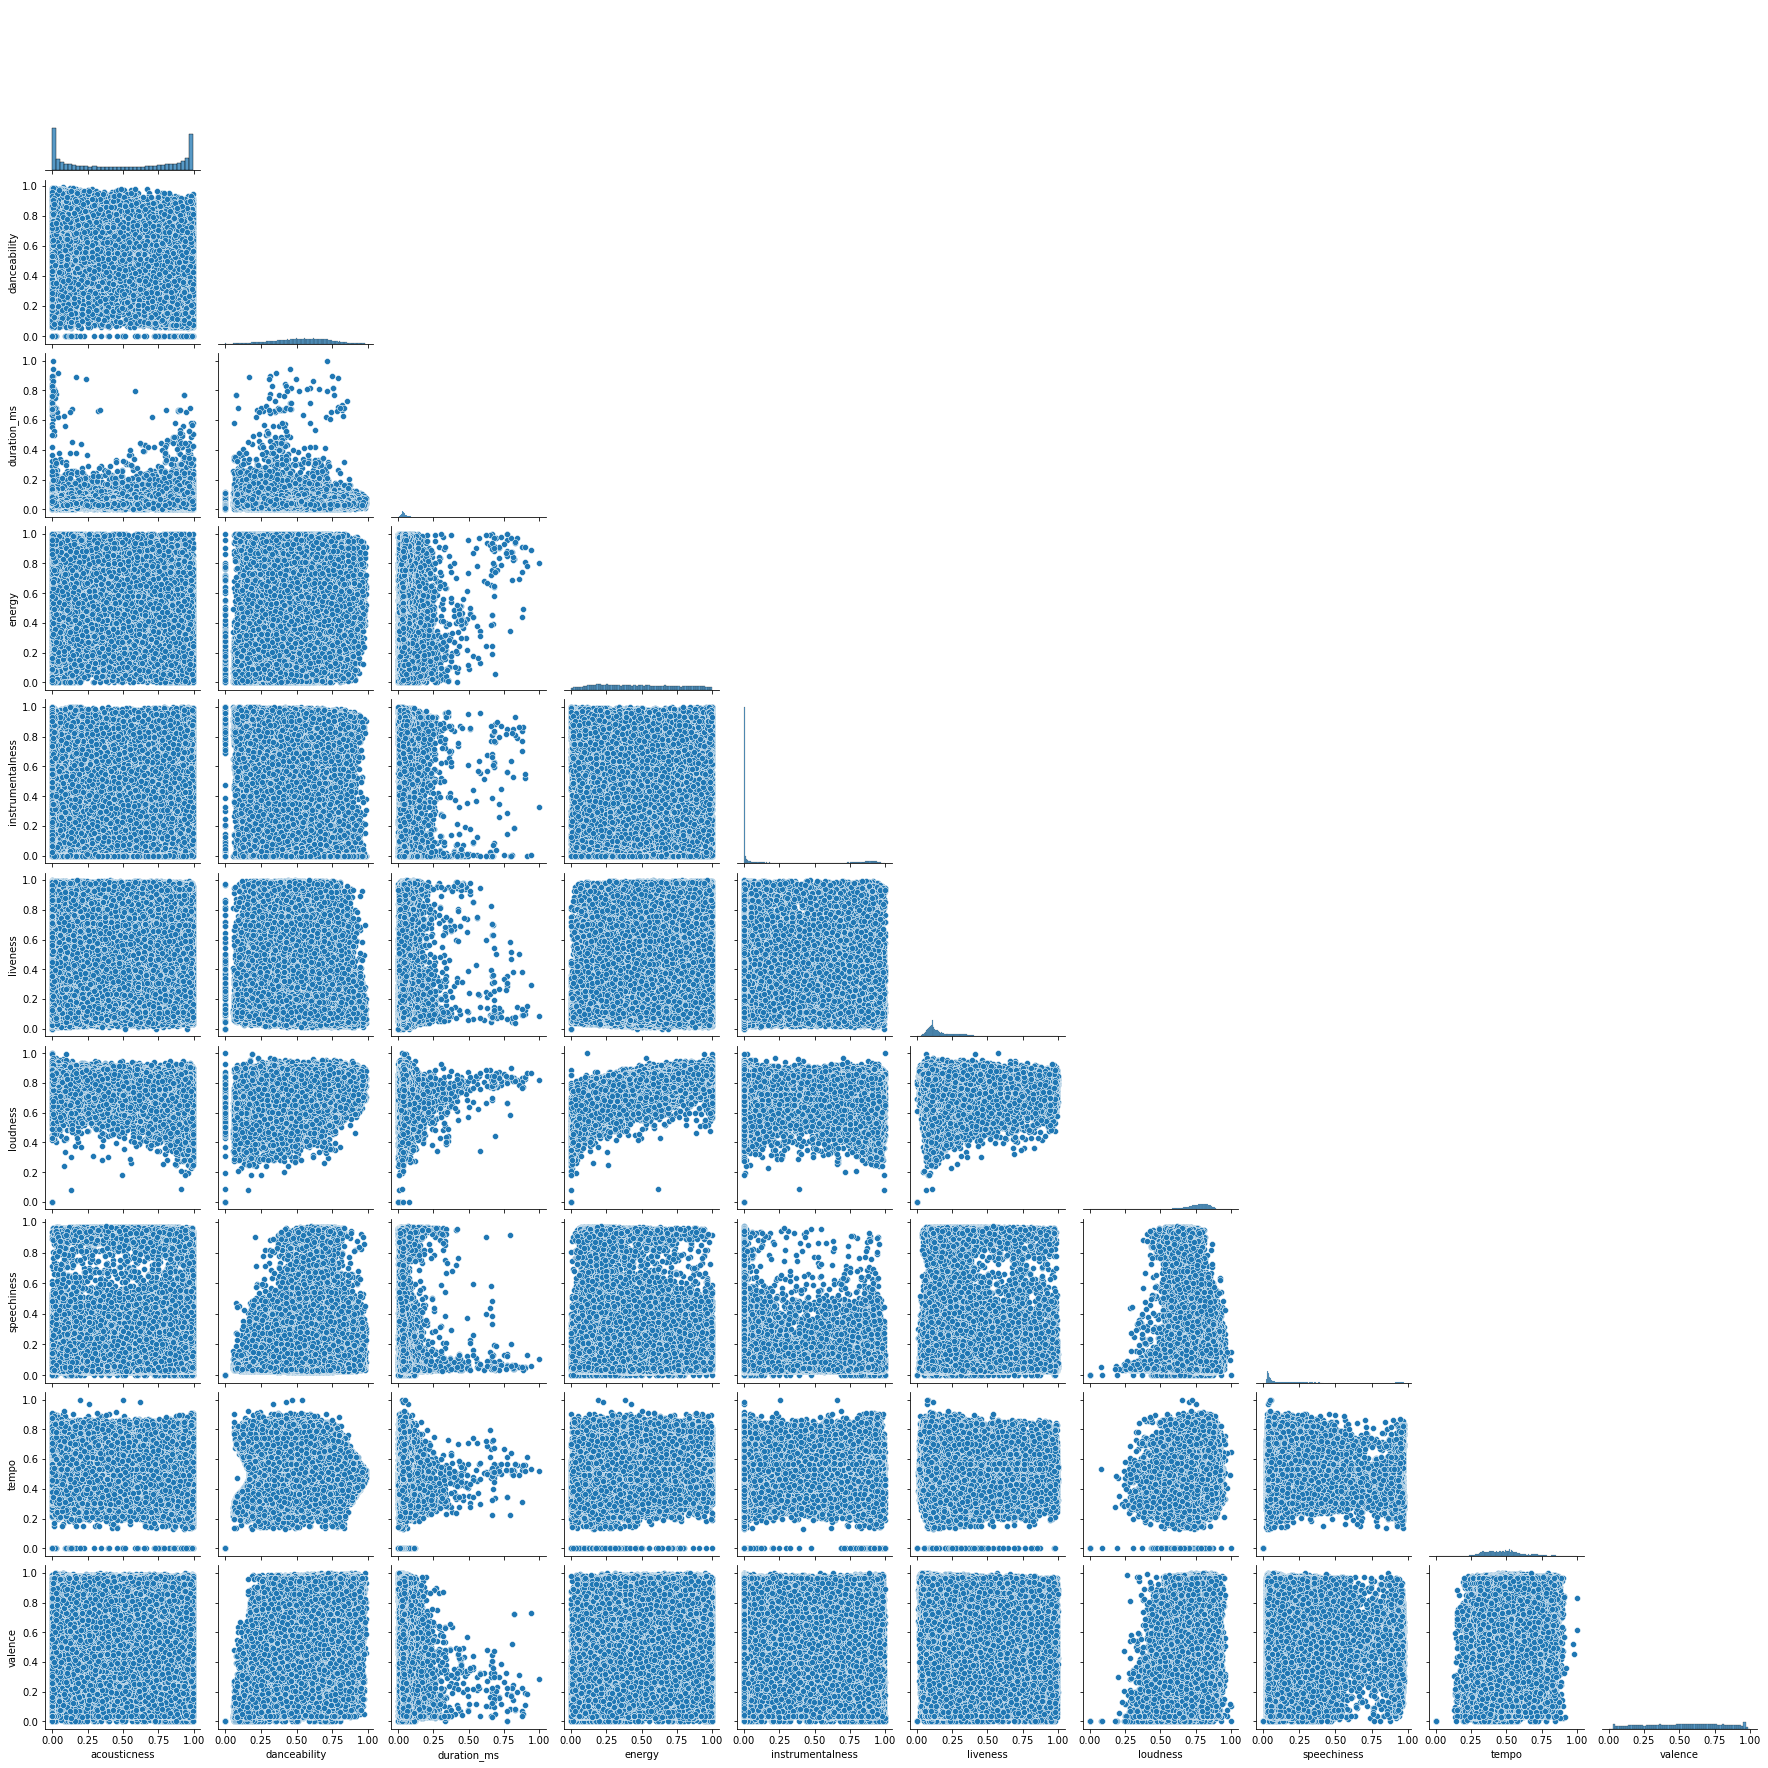

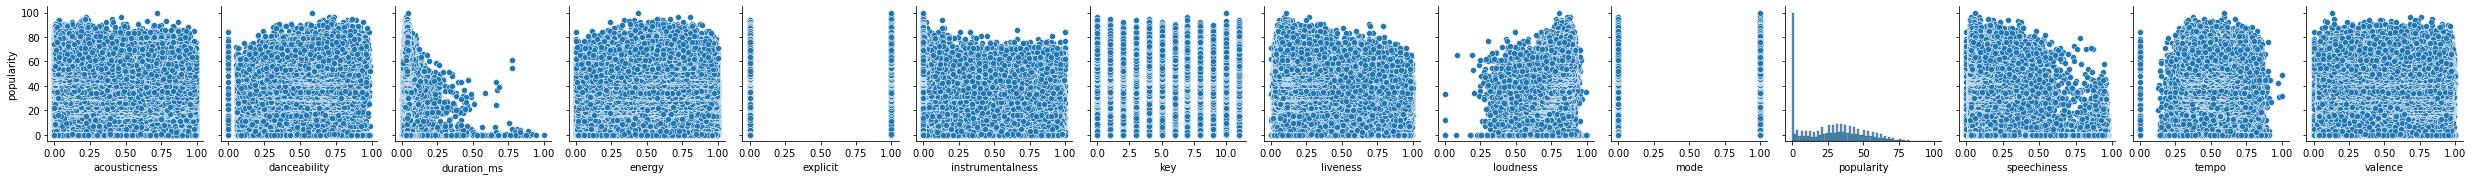

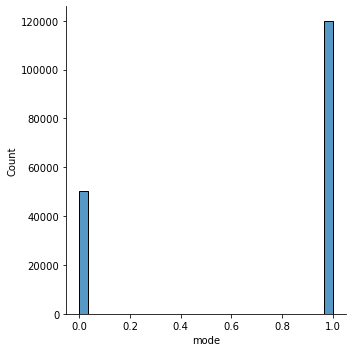

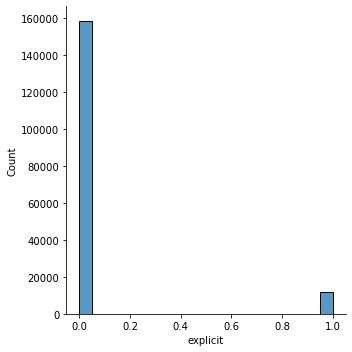

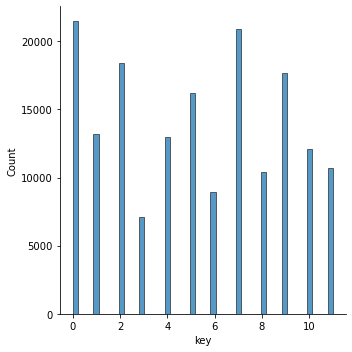

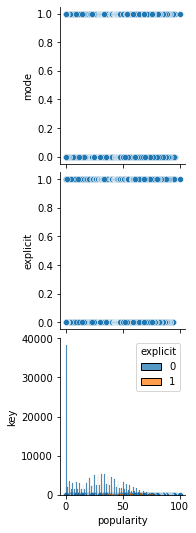

In [6]:
# Data analysis
# pair plots: https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sb

# Pairwise plots between each column in the data set excluding popularity, binary (mode and explicit) and discrete (key) features
pair_plot_data = dataset.drop(columns=['mode', 'explicit', 'key', 'popularity'])
sb.pairplot(pair_plot_data, corner=True)
# There isn't a lot of direct correlation between any two property of a song

# Correlation between each property and popularity
sb.pairplot(dataset, x_vars=usecols, y_vars=['popularity'])
# The proprties we have do not directly correlate with the popularity of a song

# Analyze binary and discrete features (mode, explicit, key)
sb.displot(data=dataset, x='mode')        # more songs are in major key
sb.displot(data=dataset, x='explicit')    # most songs are non explicit, most likely do not need this feature
sb.displot(data=dataset, x='key')         # somewhat even distribution of keys

# Analyze features in relation to popularity; these graphs are not very useful
sb.pairplot(dataset, y_vars=['mode', 'explicit', 'key'], x_vars=['popularity'])

# Count non-continuous features
non_explicit = dataset[dataset['explicit'] == 0].shape[0]
major = dataset[dataset['mode'] == 1].shape[0]
total_songs = dataset.shape[0]
print(f"Non-Explicit songs / total songs = {non_explicit/total_songs}")
print(f"Major key songs / total songs = {major/total_songs}")

# Analyze range of popularity of songs given explicit = 0 or 1 and mode = 0 or 1
sb.histplot(data=dataset, x="popularity", hue="explicit", multiple="dodge")
# sb.histplot(data=dataset, x="popularity", hue="mode", multiple="dodge")    # similar shapes for both


In [7]:
# TODO: further preprocessing?

y = dataset.pop('popularity') # popularity is our class to predict
X_headers = list(dataset.columns.values)
X = dataset

# Create the under sampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# apply the transform
X, y = undersample.fit_resample(X, y)

tempo_transformer = ReplaceZeroTransformer()
X = tempo_transformer.transform(X)

# need to scale after to treat the individual categories as their own class for the undersampling
y = y/100

In [8]:
# one hot encode the keys since they are a multiclass
ohe = OneHotEncoder(categories='auto', drop='first')

feature_arr = ohe.fit_transform(X[['key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X['key'].values))[1:]]
features = pd.DataFrame(feature_arr, columns = columns_key, index = X.index)
X = pd.concat([X, features], axis=1).drop(['key'], axis=1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [10]:
# Hyperparameter tuning

# Set the parameters by cross-validation
tuned_parameters = [
    # {
    #     'max_depth': np.arange(5, 15),
    # },
    {
        'max_depth': np.arange(1, 20),
        'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
    },
    {
        'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
        'max_leaf_nodes': np.arange(256, 324)
    },
    {
        'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
        'min_samples_split': np.arange(50, 700)
    }
]

# Available regression metrics are given here: https://scikit-learn.org/stable/modules/classes.html#regression-metric
# https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764
# ensure scikit is >0.18


inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
print("Tuning hyper-parameters begin!")
print()

# clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3)
clf = HalvingGridSearchCV(tree.DecisionTreeRegressor(random_state=1), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3, random_state=1)
print("Classifiers established, training data")
print()

clf.fit(X, y)
non_nested_scores = clf.best_score_
print("Best parameters found:", clf.best_params_)
print("Score (mean squared):", -clf.best_score_)

print("Running cross validation")
print()
clf.best_params_["random_state"] = 1
# cross_val_raw_data = cross_validate(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3, return_estimator=True, return_train_score=True)
clf = tree.DecisionTreeRegressor(**clf.best_params_)
cv_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3,  scoring='neg_mean_squared_error')
print("Cross validation score (mean squared):", -cv_score.mean())

clf.fit(X, y)

print('Feature importances:')
for i, col in enumerate(X.columns):
    print(f'{col:18}: {clf.feature_importances_[i]:.3f}')

Tuning hyper-parameters begin!

Classifiers established, training data

n_iterations: 9
n_required_iterations: 10
n_possible_iterations: 9
min_resources_: 10
max_resources_: 132427
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 37587
n_resources: 10
Fitting 5 folds for each of 37587 candidates, totalling 187935 fits
----------
iter: 1
n_candidates: 12529
n_resources: 30
Fitting 5 folds for each of 12529 candidates, totalling 62645 fits
----------
iter: 2
n_candidates: 4177
n_resources: 90
Fitting 5 folds for each of 4177 candidates, totalling 20885 fits
----------
iter: 3
n_candidates: 1393
n_resources: 270
Fitting 5 folds for each of 1393 candidates, totalling 6965 fits
----------
iter: 4
n_candidates: 465
n_resources: 810
Fitting 5 folds for each of 465 candidates, totalling 2325 fits
----------
iter: 5
n_candidates: 155
n_resources: 2430
Fitting 5 folds for each of 155 candidates, totalling 775 fits
----------
iter: 6
n_candidates: 52
n_resources: 7290
Fitt

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.9s finished


Cross validation score (mean squared): 0.025438080821589264
Feature importances:
acousticness      : 0.468
danceability      : 0.009
duration_ms       : 0.139
energy            : 0.009
explicit          : 0.144
instrumentalness  : 0.059
liveness          : 0.012
loudness          : 0.093
mode              : 0.000
speechiness       : 0.047
tempo             : 0.004
valence           : 0.016
key_1             : 0.000
key_2             : 0.000
key_3             : 0.000
key_4             : 0.000
key_5             : 0.000
key_6             : 0.000
key_7             : 0.000
key_8             : 0.000
key_9             : 0.000
key_10            : 0.000
key_11            : 0.000


In [11]:
# Report grid search results
kwargs = {'ccp_alpha': 0.0003, 'criterion': 'mse', 'max_depth': 9, 'max_leaf_nodes': 260}
clf = tree.DecisionTreeRegressor(**kwargs)
clf.fit(X_train, y_train)
print(f"r2: {clf.score(X_test, y_test)}")
print(f"rmse: {mean_squared_error(y_test, clf.predict(X_test), squared=False)}")


r2: 0.23858585395633913
rmse: 0.16552189643440846


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

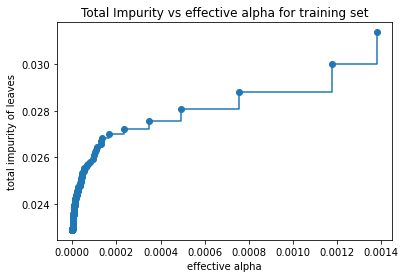

In [12]:
criteria = ["mse", "friedman_mse"] # didn't make a big difference
max_depth = 9 # found to result in best accuracy TODO: test over a range

clf = tree.DecisionTreeRegressor(criterion="mse", max_depth=max_depth)
#     clf = clf.fit(X_train, y_train)

# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# print(cross_val_score(clf, X_train, y_train, cv=cv))


# Following a tutorial on Cost Complexity Pruning https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [13]:
# generating different classifiers having different ccp_alpha values
# WARNING: this takes a very long time to run! Below, ccp_alphas is pruned to cut down on computation time.
# clfs = []
# NUM_CCP_ALPHAS = 5
# ccp_alphas = ccp_alphas[:NUM_CCP_ALPHAS]
# for ccp_alpha in ccp_alphas:   
#     print(f"ccp_alpha: {ccp_alpha}")
#     clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
#     clf.fit(X_train, y_train)
#     clfs.append(clf)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

# search for optimal ccp_alpha (seems to be somewhere in range 10**-4 to 10**-6)
# 0 (99%/-0.6%), 0.0005 (34.3%/33.4%), 0.0000005 (88.3%/5.49%)
for x in range(2,7):
    clf = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=10**-x)
    clf.fit(X_train, y_train)
    print(f"alpha: {10**-x}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))


alpha: 0.01
1.1102230246251565e-16
-3.114383982616431e-05
alpha: 0.001
0.19758385666473788
0.19255705820786606
alpha: 0.0001
0.2788679591203278
0.27259703703129856
alpha: 1e-05
0.34261560205876196
0.3204230284807018
alpha: 1e-06
0.7193646192939513
0.030827912848278793


In [14]:
# search for optimal tree depth (9)
# TODO: plot different depths to demonstrate overfitting as depth increases past 9
for md in range(2,25):
    clf = tree.DecisionTreeRegressor(random_state=0, max_depth=md)
    clf.fit(X_train, y_train)
    print(f"max_depth: {md}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))   

max_depth: 2
0.17853180744500885
0.1765397741328324
max_depth: 3
0.22258094424599162
0.21783954080355605
max_depth: 4
0.2608950958576274
0.2553544974258065
max_depth: 5
0.28905266864449064
0.2809424423990492
max_depth: 6
0.3075424411133848
0.2948593912328845
max_depth: 7
0.32601498952208907
0.3039918090664663
max_depth: 8
0.34358373888104454
0.3110267544388222
max_depth: 9
0.36338343918095806
0.3129789238791806
max_depth: 10
0.38568720218657637
0.3100995618866389
max_depth: 11
0.41181959341141583
0.2967460415402785
max_depth: 12
0.4425324165533291
0.2779587956189806
max_depth: 13
0.47918799668032264
0.2509924809066124
max_depth: 14
0.5202899154465109
0.22007268228365529
max_depth: 15
0.5636481389938959
0.1829171345679842
max_depth: 16
0.6109683694123407
0.13650086103044357
max_depth: 17
0.6580503309688234
0.095184587362939
max_depth: 18
0.7035613824335021
0.04651771134494698
max_depth: 19
0.7473986928343332
0.010360152751641039
max_depth: 20
0.7881221456285693
-0.03744862209595068
max_

In [15]:
# search for optimal max leaf nodes value (maxima somewhere in (256, 324))
for ln in range(2,25):
    max_leaf_nodes = ln**2
    clf = tree.DecisionTreeRegressor(random_state=0, max_leaf_nodes=max_leaf_nodes)
    clf.fit(X_train, y_train)
    print(f"max_leaf_node: {max_leaf_nodes}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

max_leaf_node: 4
0.19758385666473788
0.19255705820786628
max_leaf_node: 9
0.2532779519327638
0.24950826697724993
max_leaf_node: 16
0.27597414013475485
0.27062842571810697
max_leaf_node: 25
0.29406529311637075
0.2865228920588646
max_leaf_node: 36
0.3071827677438562
0.2964249307894594
max_leaf_node: 49
0.31781885114595354
0.3046003444098687
max_leaf_node: 64
0.3260764492120404
0.3118512248455937
max_leaf_node: 81
0.3330223697398462
0.3152865256390214
max_leaf_node: 100
0.3394026563965825
0.31942246180244327
max_leaf_node: 121
0.3452560611687623
0.32150497882023177
max_leaf_node: 144
0.3504531237072731
0.3240760380027339
max_leaf_node: 169
0.35533659139844187
0.3252929883285782
max_leaf_node: 196
0.3601250483977063
0.32689718065985873
max_leaf_node: 225
0.36463779502818994
0.32744173471261173
max_leaf_node: 256
0.3693891625616511
0.3271141073146021
max_leaf_node: 289
0.3739766623542131
0.32477018987536355
max_leaf_node: 324
0.37850038807243225
0.32312756203833604
max_leaf_node: 361
0.3827

In [16]:
# search for optimal min no. leaf samples
for msl in range(1,100,5):
    clf = tree.DecisionTreeRegressor(random_state=0, max_leaf_nodes=298, min_samples_leaf=msl)
    clf.fit(X_train, y_train)
    print(f"min_samples_leaf: {msl}")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

min_samples_leaf: 1
0.37513707989531087
0.3243265360771663
min_samples_leaf: 6
0.37494526754699997
0.32481682382648125
min_samples_leaf: 11
0.37449208221775776
0.3253640788789993
min_samples_leaf: 16
0.3740996493499844
0.32369870994511685
min_samples_leaf: 21
0.3736102367177344
0.3250125405477854
min_samples_leaf: 26
0.3732166685487308
0.3259275139784553
min_samples_leaf: 31
0.37278410113157046
0.3254239325455808
min_samples_leaf: 36
0.3726459874755407
0.32610665236539116
min_samples_leaf: 41
0.3723160964042842
0.3267493237702571
min_samples_leaf: 46
0.3720271022540087
0.32592620650090554
min_samples_leaf: 51
0.37182009708029284
0.32567196011339217
min_samples_leaf: 56
0.3715501705421397
0.32525384063675566
min_samples_leaf: 61
0.3706765221173779
0.324714834428511
min_samples_leaf: 66
0.37020250283390754
0.3250542655889166
min_samples_leaf: 71
0.3697997303584619
0.3251705958632696
min_samples_leaf: 76
0.3695555608767057
0.3256466248662483
min_samples_leaf: 81
0.3694678143151645
0.32627

In [17]:
# train_scores = [clf.score(X_train, y_train) for clf in clfs]
# test_scores = [clf.score(X_test, y_test) for clf in clfs]
# print(train_scores)
# print(test_scores)

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train",
#         drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#         drawstyle="steps-post")
# ax.legend()
# plt.show()

In [18]:
# TODO: perform nested cross-validation (https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

In [19]:
# Draw tree
# clf.get_depth()
# plt.figure(figsize=(50,12))
# tree.plot_tree(clf,  fontsize=10, feature_names=headers)
# plt.show()

NameError: name 'headers' is not defined

<Figure size 3600x864 with 0 Axes>